<a href="https://colab.research.google.com/github/CFA-Institute-RPC/Synthetic-Data-For-Finance/blob/main/LLM/05-Synthetic_Proportion_Impact_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the right proportion of synthetic and real data

In the last notebook, we fine-tuned a Qwen3 model on our training data and an additional 200 random synthetically generated samples, and we found performance increased from 75.29% to 85.17% on the validation dataset. In this notebook, we'll see how the performance changes for different proportions of real/synthetic data splits.

We might think that more synthetic data is better, however, if we give the model too much synthetic data it might overfit to it and not generalize well to the real data. That is, if the synthetic data doesn't adequately resemble the real data.

We train a number of Qwen3 models, each one trained on an increasing amount of synthetic data. We evaluate the performance of each one on the same validation dataset.

# Package installations

In [ ]:
!pip install --no-deps bitsandbytes==0.45.5 accelerate==1.6.0 xformers==0.0.29.post3 peft==0.15.2 trl==0.15.2 triton==3.2.0 cut_cross_entropy==25.1.1
!pip install --no-deps git+https://github.com/mmathew23/unsloth-zoo.git@t4mixed
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth==2025.5.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.7.0
    Uninstalling accelerate-1.7.0:
      Successfully uninstalled accelerate-1.7.0
  Cloning https://github.com/mmathew23/unsloth-zoo.git (to revision t4mixed) to /tmp/pip-req-build-17q8s2id
  Running command git clone --filter=blob:none --quiet https://github.com/mmathew23/unsloth-zoo.git /tmp/pip-req-build-17q8s2id
  Running command git checkout -b t4mixed --track origin/t4mixed
  Switched to a new branch 't4mixed'
  Branch 't4mixed' set up to track remote branch 't4mixed' from 'origin'.
  Resolved https://github.com/mmathew23/unsloth-zoo.git to commit a05a9a46013a46f1d9ff90f8d47db2cb6b6e

# Importing libraries

In [ ]:
# Import libraries
import torch
major_version, minor_version = torch.cuda.get_device_capability() # Outputs GPU compute capability version (major) and indicator (minor)
print(f"Major: {major_version}, Minor: {minor_version}")
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import random
from tqdm import tqdm # Add progress bar to for loops
from unsloth import FastLanguageModel
from unsloth import tokenizer_utils
from transformers import AutoTokenizer, Qwen3ForSequenceClassification
import torch.nn.functional as F
from peft import LoftQConfig
from transformers import DataCollatorForLanguageModeling
from typing import List, Dict, Union, Any
from sklearn.metrics import f1_score, classification_report
from trl import SFTTrainer
from transformers import TrainingArguments
import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



Major: 7, Minor: 5
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# In order to speed up fine-tuning, we trim the size of the classification head to contain only the number tokens (1, 2 etc) which reduces memory usage.
# The function below doesn't work if we alter the classification head of the model in this way - so we overwrite this function to not do anything
def do_nothing(*args, **kwargs):
  pass

tokenizer_utils.fix_untrained_tokens = do_nothing

In [ ]:
# Load model
model_name = "unsloth/Qwen3-0.6B-Base";load_in_4bit = False # load_in_4bit controls whether to use 4-bit quantization for model weights to speed up training

# Number of sentiment classes
NUM_CLASSES = 3

# Defines the max no. of tokens in an input sentence. Unsloth uses RoPE scaling internally which means it doesn't matter if the LLM sees an input that is longer than this, so any number is fine. We stick with the default 2048.
max_seq_length = 2048

dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


In [ ]:
# Create custom collator class overriding HF one (needed to map old -> new tokenizer)
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
  def __init__(
      self,
      *args,
      reverse_map: Dict[int, int],
      mlm: bool = False, # Disable masked language modeling (mlm)
      ignore_index: int = -100, # Used to specify label indices to be ignored using the calculation of cross-entropy loss (e.g if we don't care about class label 0, we set ignore_index=0)
      **kwargs,
  ):

    super().__init__(*args, mlm=mlm, **kwargs) # Call the parent class (DataCollatorForLanguageModeling  and set mlm=False)
    self.ignore_index = ignore_index # Set the ignore_index value in the parent class
    self.reverse_map = reverse_map

  def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
    batch = super().torch_call(examples) # Define the batch of training examples

    for i in range(len(examples)):
      # For each batch of examples, get the labels we're interested in predicting, get the pytorch tensor using .nonzero(), get the last row using [-1]
      last_token_idx = (batch['labels'][i] != self.ignore_index).nonzero()[-1].item()
      # Set all labels to ignore_index except for the last token
      batch['labels'][i, :last_token_idx] = self.ignore_index

      # If the last token in the sentence is 0,1,2, or 3, this was processed with the old tokenizer as number_token_ids[1], number_token_ids[2] etc.
      # However, these indexes don't exist in the new classification head, so we map the indexes to the new lm_head index instead
      batch['labels'][i, last_token_idx] = self.reverse_map[ batch['labels'][i, last_token_idx].item() ]

    return batch

# Setting up the workflow - defining functions
In the code below we create various functions that we'll use when fine-tuning each Qwen3 model.

In [ ]:
def prepare_model(model_name, NUM_CLASSES):

  ''' Load the model, restructure the classification head and create custom collator
  mapping token IDs from old tokenizer to new tokenizer
  '''

  ### Load model and tokenizer
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_name,load_in_4bit = False,
      max_seq_length = 2048,
      dtype = None,  # None for auto detection
      #force_download=True,
)
  ### Trim the classification head so the model can only output numbers 0-NUM_classes (0 is kept to make everything simpler)
  number_token_ids = []
  # Find and store the tokenizer-encoded representations of each label class (0,1,2,3) (we don't use 0 as a class label but we keep it for simplicity)
  for i in range(0, NUM_CLASSES+1):
    number_token_ids.append(tokenizer.encode(str(i), add_special_tokens=False)[0])
    # Keep only the number tokens from lm_head

  # Keep only the weights corresponding to prediction of our class labels - we will train these weights during the fine-tuning process.
  par = torch.nn.Parameter(model.lm_head.weight[number_token_ids,:])

  old_shape = model.lm_head.weight.shape
  old_size = old_shape[0]
  # Modify the shape of the classification head to par
  model.lm_head.weight = par
  reverse_map = {value: idx for idx, value in enumerate(number_token_ids)} # Used later to conver

  # Define custom collator mapping old tokenizer to new one
  collator = DataCollatorForLastTokenLM(tokenizer=tokenizer,reverse_map=reverse_map)

  return model, tokenizer, reverse_map, number_token_ids, collator, old_size

In [ ]:
def add_qlora(model):

  '''
  Add QLoRA to each model
  '''

  model = FastLanguageModel.get_peft_model(
      model,
      r= 16,
      target_modules = [
          'lm_head',
          'q_proj','k_proj','v_proj','o_proj',
          'gate_proj','up_proj','down_proj'],
      lora_alpha = 16,
      lora_dropout = 0,
      bias = 'none',
      use_gradient_checkpointing = 'unsloth',
      random_state = 42,
      use_rslora = True,
  )
  return model

In [ ]:
# Fine-tuning loop
def fine_tuning(model,tokenizer,train_dataset,collator):

   ''' Set up the fine-tuning parameters and convert each dataset into LLM-friendly format
  '''


  # Convert pd dataframe to HF dataset
  train_dataset = datasets.Dataset.from_pandas(train_dataset, preserve_index=False)

  ### Set up trainer and fine-tune model
  trainer = SFTTrainer(
      model = model,
      tokenizer = tokenizer,
      train_dataset = train_dataset,
      max_seq_length = 2048,
      dataset_num_proc = 1,
      packing = False,
      args = TrainingArguments(
          per_device_train_batch_size = 32,
          gradient_accumulation_steps = 1,
          warmup_steps = 10,
          learning_rate = 1e-4,
          fp16 = not torch.cuda.is_bf16_supported(),
          bf16 = torch.cuda.is_bf16_supported(),
          optim = 'adamw_8bit',
          weight_decay = 0.01,
          lr_scheduler_type='cosine',
          seed = 42,
          output_dir = 'outputs',
          num_train_epochs = 3,
          report_to = 'none',
          group_by_length = True
      ),
      data_collator = collator,
      dataset_text_field = 'sentence'
      )

  ### Start fine-tuning
  trainer_stats = trainer.train()

  ### Speed up inference
  FastLanguageModel.for_inference(model)

  return model

In [ ]:
def restructure_lm_head(model,old_size,number_token_ids):
  '''
  Restructure LM head back to original size after training
  '''

  # Save the current (trimmed) lm_head and bias
  trimmed_lm_head = model.lm_head.weight.data.clone()
  trimmed_lm_head_bias = model.lm_head.bias.data.clone() if hasattr(model.lm_head, "bias") and model.lm_head.bias is not None else torch.zeros(len(number_token_ids), device=trimmed_lm_head.device)

  # Create a new lm_head with shape [old_size, hidden_dim]
  hidden_dim = trimmed_lm_head.shape[1]
  new_lm_head = torch.full((old_size, hidden_dim), 0, dtype=trimmed_lm_head.dtype, device=trimmed_lm_head.device)
  new_lm_head_bias = torch.full((old_size,), -1000.0, dtype=trimmed_lm_head_bias.dtype, device=trimmed_lm_head_bias.device)

  # Fill in the weights and bias for the allowed tokens (number_token_ids)
  for new_idx, orig_token_id in enumerate(number_token_ids):
    new_lm_head[orig_token_id] = trimmed_lm_head[new_idx]
    new_lm_head_bias[orig_token_id] = trimmed_lm_head_bias[new_idx]

  # Update the model's lm_head weight and bias
  with torch.no_grad():
    new_lm_head_module = torch.nn.Linear(hidden_dim, old_size, bias=True, device=model.device)
    new_lm_head_module.weight.data.copy_(new_lm_head)
    new_lm_head_module.bias.data.copy_(new_lm_head_bias)
    model.lm_head.modules_to_save["default"] = new_lm_head_module

  return model

In [ ]:
def evaluate_performance(model,tokenizer,validation_dataset,batch_size,device,number_token_ids):
  '''
  Evaluate performance on validation dataset, store results
  '''
  # Sort validation samples by token length (speeds up inference)
  validation_dataset['token_length'] = validation_dataset['sentence'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
  val_sorted = validation_dataset.sort_values(by='token_length').reset_index(drop=True)

  # Create inference prompt for the model
  prompt = """Here is a sentence related to a company:
  {}

  Classify the sentiment into one of the following:
  class 1: Negative
  class 2: Neutral
  class 3: Positive

  SOLUTION
  The correct answer is: class {}"""

  inference_prompt_template = prompt.split('class {}')[0] + 'class '

  correct = 0
  y_pred = []
  y_true = []
  with torch.inference_mode():
    for i in tqdm(range(0, len(val_sorted), batch_size), desc="Evaluating"):
        batch = val_sorted.iloc[i:i+batch_size]
        prompts = [inference_prompt_template.format(text) for text in batch['sentence']]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(device)
        logits = model(**inputs).logits
        last_idxs = inputs.attention_mask.sum(1) - 1
        last_logits = logits[torch.arange(len(batch)), last_idxs, :]
        probs_all = F.softmax(last_logits, dim=-1)
        probs = probs_all[:, number_token_ids] # only keep the logits for the number tokens
        preds = torch.argmax(probs, dim=-1).cpu().numpy() # looks like [1 1 1 1 3 1 3 1 3 1 1 1 1 2 2 3]

        y_pred.extend(preds.tolist()) # Append predicted labels to list
        y_true.extend(batch['label'].tolist()) # Append true labels to list

        true_labels = batch['label'].tolist()
        correct += sum([p == t for p, t in zip(preds, true_labels)])

  overall_accuracy = 100 * correct / len(validation_dataset)
  f1_weighted = f1_score(y_true, y_pred, average='weighted')
  #print(f"\nValidation accuracy (Overall): {overall_accuracy:.2f}% ({correct}/{len(validation_dataset)})")
  #print(f"\nValidation weighted F1-score: {f1_weighted:.4f}")

  return y_pred, y_true, overall_accuracy, f1_weighted


# Set up the training loop


Now that we've defined all our functions, we add them all into one training loop function. We'll call this function for each model.

In [ ]:
def training_loop(model_name, NUM_CLASSES, training_dataset,validation_dataset,batch_size):

  # Prepare model
  model, tokenizer, reverse_map, number_token_ids, collator,old_size = prepare_model(model_name, NUM_CLASSES)

  # Add QLoRA to model
  model = add_qlora(model)

  device=model.device

  # Fine-tuning
  model = fine_tuning(model,tokenizer,training_dataset,collator)

  # Restructure back to old-head size
  model = restructure_lm_head(model,old_size,number_token_ids)

  # Test performance on validation dataset
  y_pred, y_true, overall_accuracy, f1_weighted = evaluate_performance(model,tokenizer,validation_dataset,batch_size,device,number_token_ids)

  return y_pred, y_true, overall_accuracy, f1_weighted


# Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('drive/MyDrive/data/train.csv')
synthetic_data = pd.read_csv('drive/MyDrive/data/gpt_synthetic_data.csv',index_col=0)

# Total number of synthetic data samples
#n_rows = len(synthetic_data)
syn_subsamples = [] # List to store subsampled datasets

# Create list of synthetic data subsets, each one with 100 more samples than the previous one
for n in range(100, len(synthetic_data)+100, 100):
  subset = synthetic_data.sample(n=n,random_state=42)
  syn_subsamples.append(subset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Formatting the data

In [ ]:
# Create list of augmented train + synthetic datasets
augmented_datasets = [train]

for subset in range(0,len(syn_subsamples)):

  augmented_data = pd.concat([train,syn_subsamples[subset]])
  augmented_datasets.append(augmented_data)


# Create prompt for the Qwen3 model
prompt = """Here is a sentence related to a company:
{}

Classify the sentiment into one of the following:
class 1: Negative
class 2: Neutral
class 3: Positive

SOLUTION
The correct answer is: class {}"""


# This function takes a dataset as input, and for each row in the dataset, formats it into an LLM prompt such that the first {} is filled with the sentence and the second {} is the label.
def formatting_prompts_func(dataset_):
  sentences = []
  for i in range(len(dataset_['sentence'])):
    sentence_ = dataset_['sentence'].iloc[i]
    label_ = dataset_['label'].iloc[i]

    sentence = prompt.format(sentence_, label_)

    sentences.append(sentence)
  return sentences

# Format each sentence to prompt form in each augmented dataset
for dataset in range(0,len(augmented_datasets)):
  augmented_datasets[dataset]['sentence'] = formatting_prompts_func(augmented_datasets[dataset])


In [ ]:
# Set up the validation dataset
validation_dataset = pd.read_csv('drive/MyDrive/data/val.csv')

In [ ]:
identifiers = ['Real', 'Real + 100 synthetic', 'Real + 200 synthetic','Real + 300 synthetic',
               'Real + 400 synthetic','Real + 500 synthetic',
               'Real + 600 synthetic','Real + 700 synthetic','Real + 800 synthetic']

In [ ]:
results = {}
# Loop through each dataset, fine-tuning a separate Qwen3 model each time, assessing its performance on the validation dataset and storing the results.
for i in tqdm(range(0,len(augmented_datasets))):
  augmented_dataset = augmented_datasets[i]
  identifier = identifiers[i]

  print("\n" + "=" * 60)
  print(f"🔄 Training and Evaluating for: {identifier}")
  print("=" * 60 + "\n")

  y_pred, y_true, overall_accuracy, f1_weighted = training_loop(model_name, NUM_CLASSES, augmented_dataset,validation_dataset,batch_size=16)
  results[identifier] = {
      'y_pred': y_pred,
      'y_true': y_true,
      'overall_accuracy': overall_accuracy,
      'f1_weighted': f1_weighted
  }


  0%|          | 0/9 [00:00<?, ?it/s]


🔄 Training and Evaluating for: Real

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/822 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 822 | Num Epochs = 3 | Total steps = 78
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 11%|█         | 1/9 [01:23<11:10, 83.83s/it]


🔄 Training and Evaluating for: Real + 100 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/922 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 922 | Num Epochs = 3 | Total steps = 87
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 22%|██▏       | 2/9 [02:51<10:01, 85.91s/it]


🔄 Training and Evaluating for: Real + 200 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1022 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,022 | Num Epochs = 3 | Total steps = 96
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 33%|███▎      | 3/9 [04:24<08:57, 89.50s/it]


🔄 Training and Evaluating for: Real + 300 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1122 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,122 | Num Epochs = 3 | Total steps = 108
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 44%|████▍     | 4/9 [06:09<07:56, 95.25s/it]


🔄 Training and Evaluating for: Real + 400 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1222 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,222 | Num Epochs = 3 | Total steps = 117
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 56%|█████▌    | 5/9 [07:57<06:39, 99.89s/it]


🔄 Training and Evaluating for: Real + 500 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1322 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,322 | Num Epochs = 3 | Total steps = 126
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 67%|██████▋   | 6/9 [09:52<05:15, 105.07s/it]


🔄 Training and Evaluating for: Real + 600 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1422 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,422 | Num Epochs = 3 | Total steps = 135
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 78%|███████▊  | 7/9 [11:56<03:42, 111.41s/it]


🔄 Training and Evaluating for: Real + 700 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1522 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,522 | Num Epochs = 3 | Total steps = 144
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



 89%|████████▉ | 8/9 [14:04<01:56, 116.72s/it]


🔄 Training and Evaluating for: Real + 800 synthetic

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


Unsloth: Tokenizing ["sentence"]:   0%|          | 0/1622 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,622 | Num Epochs = 3 | Total steps = 153
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 10,096,640/606,150,656 (1.67% trained)


Step,Training Loss



100%|██████████| 9/9 [16:18<00:00, 108.69s/it]


In [ ]:
# Print the results of each model.
for identifier, metrics in results.items():
    accuracy = metrics['overall_accuracy']
    f1 = metrics['f1_weighted']*100

    print(f"{identifier}")
    print(f"   - Accuracy          : {round(accuracy,2)}")
    print(f"   - F1 Score (Weighted):{f1:.2f}\n")

Real
   - Accuracy          : 75.21
   - F1 Score (Weighted):75.12

Real + 100 synthetic
   - Accuracy          : 82.05
   - F1 Score (Weighted):82.19

Real + 200 synthetic
   - Accuracy          : 82.91
   - F1 Score (Weighted):83.76

Real + 300 synthetic
   - Accuracy          : 71.79
   - F1 Score (Weighted):71.57

Real + 400 synthetic
   - Accuracy          : 73.5
   - F1 Score (Weighted):73.29

Real + 500 synthetic
   - Accuracy          : 70.94
   - F1 Score (Weighted):70.64

Real + 600 synthetic
   - Accuracy          : 71.79
   - F1 Score (Weighted):71.44

Real + 700 synthetic
   - Accuracy          : 71.79
   - F1 Score (Weighted):71.79

Real + 800 synthetic
   - Accuracy          : 71.79
   - F1 Score (Weighted):71.69



We see varying results - in this example the model trained on Real + 200 synthetic samples performed the best, with a drop-off in performance on increasing proportions of synthetic data. There are a couple of reasons that could explain this finding. Firstly, our validation dataset only contains negative and positive sentiment classes, whereas our synthetic data contains a large number of neutral classes as well. Consequently, by increasing the number of these classes through the addition of more synthetic data samples, we are adding 'noise' to our training data that might limit the model's ability to predict the negative and positive sentiment classes. One way to test this would be to generate some more synthetic data but instruct GPT4-o to only produce positive and negative sentiment labels, to see if that changes anything.

Secondly, the effects of synthetic data are strongest when our training data is small. If our training dataset only consisted of 100 samples, it's likely we'd find further improvements with larger quantities of synthetic data.

Lastly, rerunning this notebook using different sampling seed would lead to different synthetic data subsamples, which would also change the results for better or worse, by changing the dataset that each model is fine-tuned on.

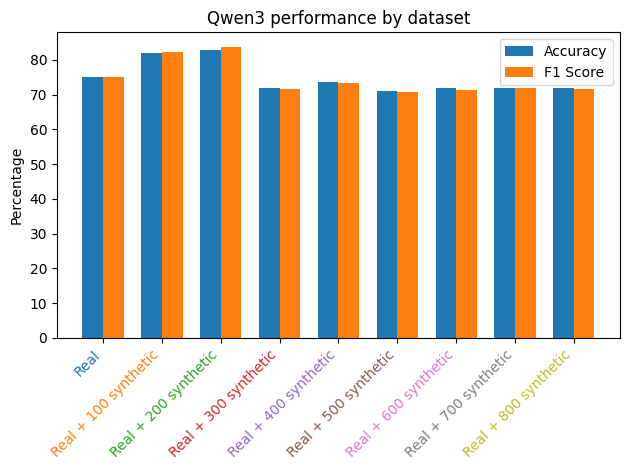

In [ ]:
import matplotlib.pyplot as plt

accuracies = [metrics['overall_accuracy'] for metrics in results.values()]
f1_scores = [metrics['f1_weighted'] * 100 for metrics in results.values()]

x = range(len(identifiers))
width = 0.35

# Create the grouped bar chart
fig, ax = plt.subplots()
ax.bar([i - width/2 for i in x], accuracies, width, label='Accuracy')
ax.bar([i + width/2 for i in x], f1_scores, width, label='F1 Score')

ax.set_ylabel('Percentage')
ax.set_title('Qwen3 performance by dataset')
ax.set_xticks(x)
xticklabels = ax.set_xticklabels(identifiers)
plt.xticks(rotation=45, ha='right')
# Color each x-tick label distinctly
for label, color in zip(xticklabels, plt.cm.tab10.colors):
    label.set_color(color)

ax.legend()
plt.tight_layout()
plt.show()
